In [33]:
### Imports
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv

In [34]:
# Load LLMs
load_dotenv()
base_url = "http://192.168.0.108:11434"

# router_llm = "llama3.2:3b-instruct-fp16"
# router_llm = "llama3-groq-tool-use:latest"
router_llm = "qwen2.5:14b"
llm = ChatOllama(model=router_llm, temperature=0, base_url=base_url, validate_model_on_init=True)

In [35]:
query = "Hi!"
response = llm.invoke([{"role": "user", "content": query}])
response.text()

'Hello! How can I assist you today? Feel free to ask me anything or let me know if you have any questions.'

In [36]:
llm.invoke([HumanMessage(content="Hi! I'm Bob")])

AIMessage(content="Hello Bob! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-08-17T16:57:22.695374782Z', 'done': True, 'done_reason': 'stop', 'total_duration': 607484440, 'load_duration': 102963455, 'prompt_eval_count': 34, 'prompt_eval_duration': 56125069, 'eval_count': 18, 'eval_duration': 437169347, 'model_name': 'qwen2.5:14b'}, id='run--704ae3ef-f943-4fde-b33c-e8f0d4dd7915-0', usage_metadata={'input_tokens': 34, 'output_tokens': 18, 'total_tokens': 52})

In [37]:
llm.invoke([HumanMessage(content="What's my name?")])

AIMessage(content="As an artificial intelligence, I don't have information about your personal identity unless you provide it to me. What would you like to know or discuss?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-08-17T16:57:23.596288379Z', 'done': True, 'done_reason': 'stop', 'total_duration': 881131671, 'load_duration': 94984456, 'prompt_eval_count': 34, 'prompt_eval_duration': 32765721, 'eval_count': 31, 'eval_duration': 742055519, 'model_name': 'qwen2.5:14b'}, id='run--3f0ad1cd-39d2-433c-9794-ce8ca2fa1a6e-0', usage_metadata={'input_tokens': 34, 'output_tokens': 31, 'total_tokens': 65})

We can see that it doesn't take the previous conversation turn into context, and cannot answer the question. This makes for a terrible chatbot experience!

To get around this, we need to pass the entire conversation history into the model. Let's see what happens when we do that:

In [38]:
response = llm.invoke(
    [
        HumanMessage(content="Hi! I'm Bob"),
        AIMessage(content="Hello Bob! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
)

In [39]:
print(f"Message content: {response.text()}\n")
print(f"Tool calls: {response.tool_calls}")

Message content: Your name is Bob, as you just introduced yourself to me. Is there anything specific you would like help with, Bob?

Tool calls: []


### Prompt templates
Prompt Templates help to turn raw user information into a format that the LLM can work with. In this case, the raw user input is just a message, which we are passing to the LLM. Let's now make that a bit more complicated. First, let's add in a system message with some custom instructions (but still taking messages as input). Next, we'll add in more input besides just the messages.

To add in a system message, we will create a ChatPromptTemplate. We will utilize MessagesPlaceholder to pass all the messages in.

In [40]:
from langchain_core.messages import ChatMessage
prompt_template = ChatPromptTemplate.from_messages(
    [
        
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}. "
            "Think twice and use your memory to answer past questions or user interactions."
            "For translation questions, use the websearch tool. "
            "For question to an expert or representative, use the human_assistance tool. "
            "For question such as about current events , use WebSearch tool.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

One important concept to understand when building chatbots is how to manage conversation history. If left unmanaged, the list of messages will grow unbounded and potentially overflow the context window of the LLM. Therefore, it is important to add a step that limits the size of the messages you are passing in.

Importantly, you will want to do this BEFORE the prompt template but AFTER you load previous messages from Message History.

We can do this by adding a simple step in front of the prompt that modifies the messages key appropriately, and then wrap that new chain in the Message History class.

LangChain comes with a few built-in helpers for managing a list of messages. In this case we'll use the trim_messages helper to reduce how many messages we're sending to the model. The trimmer allows us to specify how many tokens we want to keep, along with other parameters like if we want to always keep the system message and whether to allow partial messages:

In [41]:
from langchain_core.messages import SystemMessage, trim_messages
from langchain_core.messages.utils import count_tokens_approximately


trimmer = trim_messages(
    # Keep the last <= n_count tokens of the messages.
    strategy="last",
    # Remember to adjust based on your model
    # or else pass a custom token_counter
    token_counter=len,
    # Most chat models expect that chat history starts with either:
    # (1) a HumanMessage or
    # (2) a SystemMessage followed by a HumanMessage
    # Remember to adjust based on the desired conversation
    # length
    max_tokens=45,
    # Most chat models expect that chat history starts with either:
    # (1) a HumanMessage or
    # (2) a SystemMessage followed by a HumanMessage
    start_on="human",
    # Most chat models expect that chat history ends with either:
    # (1) a HumanMessage or
    # (2) a ToolMessage
    end_on=("human", "tool"),
    # Usually, we want to keep the SystemMessage
    # if it's present in the original history.
    # The SystemMessage has special instructions for the model.
    include_system=True,
    # allow_partial=False,
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

# Test the trimmer
trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={})]

In [42]:
# Web Search Tool - Serperdev
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

search = GoogleSerperAPIWrapper()
web_search_tool = Tool(
    name="WebSearch",
    func=search.run,
    description="useful for when you need to do a web search",
)
question = "What is the weather like in SF?"
print(web_search_tool.invoke({"query": question}))


Partly cloudy skies. Expect mist and reduced visibilities at times. Low 57F. Winds W at 10 to 20 mph. Humidity87%. UV Index0 of ... San Francisco, CA Forecast · Morning. 57°. -- · Afternoon. 61°. -- · Evening. 57°. Chance of Rain3% · Overnight. 54°. Chance of Rain12%. SF is cool and often foggy. 25C is pretty rare, but so is less than 10C. Even if it hits 30C, it almost always goes below 20C at night. I've ... Hourly Weather · 1 PM 67°. rain drop 5% · 2 PM 68°. rain drop 0% · 3 PM 69°. rain drop 0% · 4 PM 68°. rain drop 0% · 5 PM 67°. rain drop 0% · 6 PM 66°. rain ... Sun 15 · 63 · Sunshine and clouds mixed. High 63F. Winds W at 15 to 25 mph. ; Mon 16 · 63 · Some clouds in the morning will give way to mainly sunny skies for the ... Afternoon. Mainly cloudy. 17°. Feels 17 · 30% ; Evening. Partly cloudy. 16°. Feels 15 · 20% ; Overnight. Fog patches. 13°. Feels 11 · 30%. ... weather forecast for San Francisco ... Drizzle and a gentle breeze. Humidity: 88%; Pressure: 1014 mb; Visibility: M

In [43]:
# Bind tool to an LLM

tools = [web_search_tool]
llm_with_tools = llm.bind_tools(tools)

In [44]:
# Testing the model with tools :This time it SHOULD NOT decide to use the web search tool
import pprint as pp


result = llm_with_tools.invoke(
    [HumanMessage(content="Hi Im Alex?")]
)

pp.pprint(result.model_dump())

{'additional_kwargs': {},
 'content': 'Hello Alex! How can I assist you today?',
 'example': False,
 'id': 'run--801bdfdd-90dc-47d9-ac3b-e6a1dbf7004c-0',
 'invalid_tool_calls': [],
 'name': None,
 'response_metadata': {'created_at': '2025-08-17T16:57:25.894949404Z',
                       'done': True,
                       'done_reason': 'stop',
                       'eval_count': 11,
                       'eval_duration': 299185084,
                       'load_duration': 103450271,
                       'model': 'qwen2.5:14b',
                       'model_name': 'qwen2.5:14b',
                       'prompt_eval_count': 166,
                       'prompt_eval_duration': 76492767,
                       'total_duration': 488816075},
 'tool_calls': [],
 'type': 'ai',
 'usage_metadata': {'input_tokens': 166,
                    'output_tokens': 11,
                    'total_tokens': 177}}


In [45]:
# Testing the model with tools :This time it should decide to use the web search tool
import pprint as pp

# # This is the prompt template that we defined earlier
# prompt = prompt_template.invoke(
#     {"messages": [HumanMessage(content="What is the weather?")], "language": "English"}
# )

result = llm_with_tools.invoke([HumanMessage(content="What is langgraph?")])

pp.pprint(result.model_dump())

{'additional_kwargs': {},
 'content': 'I couldn\'t find specific information about "langgraph" as it\'s '
            'not a widely recognized term or product. It seems like you might '
            'be referring to something specific within a certain context, such '
            'as a project name, library, or tool related to language '
            'processing or graph theory. Could you provide more details so I '
            "can help you better? If you're unsure about the exact term but "
            'have an idea of what it does, feel free to describe its '
            "functionality and I'll try to find relevant information for you.",
 'example': False,
 'id': 'run--4f1227b2-0108-416e-9323-d7198f934f75-0',
 'invalid_tool_calls': [],
 'name': None,
 'response_metadata': {'created_at': '2025-08-17T16:57:28.485835288Z',
                       'done': True,
                       'done_reason': 'stop',
                       'eval_count': 102,
                       'eval_duration': 242

### Langgraph app
Wrapping our chat model in a minimal LangGraph application allows us to automatically persist the message history, simplifying the development of multi-turn applications.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its documentation for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

In [46]:
# Graph state


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

In [47]:
# Bind tool to an LLM
import json

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""

    human_response = interrupt({"query": query, "expected_output": {"data": "string"}})
    if not human_response or "data" not in human_response:
        raise ValueError("Human response is missing or invalid.")
    if not isinstance(human_response["data"], str):
        raise TypeError("Human response data should be a string.")
    return human_response["data"]
    



tools = [web_search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

In [48]:
from typing import Literal
from langchain_core.runnables import RunnableConfig

# Define a new graph
workflow = StateGraph(State)


# Define the function that calls the model
def call_model(
    state: State,
    config: RunnableConfig,
) -> dict[str, Sequence[BaseMessage]]:
    """Call the model with the current state."""
    # Conversation History management:
    # Use the trimmer to get the messages that fit within the token limit
    trimmed_messages = trimmer.invoke(state["messages"])
    # and then invoke the prompt template with those messages
    # and the language from the state.

    # This is the prompt template that we defined earlier
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )

    message = llm_with_tools.invoke(prompt, config=config)
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1

    return {"messages": [message]}


def human_approval(state: State) -> Command[Literal["tools", "assistant"]]:
    is_approved = interrupt(
        {
            "question": "Is this correct?",
            # Surface the output that should be
            # reviewed and approved by the human.
            "llm_output": state["llm_output"],
        }
    )

    if is_approved:
        return Command(goto="tools")
    else:
        return Command(goto="assistant")


# Define the nodes in the graph
workflow.add_node("assistant", call_model)
workflow.add_node("tools", ToolNode(tools=tools))
workflow.add_conditional_edges(
    "assistant",
    tools_condition)   

# # Define the edges in the graph
workflow.add_edge(START, "assistant")
workflow.add_edge("tools", "assistant")
# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc32454"}}

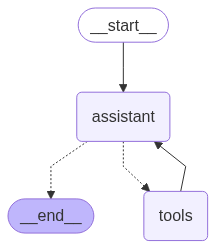

In [49]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [50]:
language = "English"

async def stream_graph_updates(user_input: Command | str):
    async for step in app.astream(input=user_input, config=config, stream_mode="values"):
        # for value in step.values():
        #     print("Assistant:", value["messages"][-1].content)
        step["messages"][-1].pretty_print()


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        user_input = {
            "messages": [{"role": "user", "content": user_input}],
            "language": language
        }
        # Stream updates from the graph
        await stream_graph_updates(user_input)
        # If human input is needed, it will be handled by the human_assistance tool
        resume_map = {}

        for i in app.get_state(config).interrupts:
            prpmp = f"Human input for: I need help with {i.value["query"]}. Expected output: {i.value['expected_output']}"
            print(prpmp)
            output = i.value["expected_output"]
            resume_map[i.id] = {
                k: input("Input for " + k + ": ") for k, v in output.items()
            }

        await stream_graph_updates(Command(resume=resume_map))
    except Exception as e:
        print(f"An error occurred: {e}")
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"

        print("User: " + user_input)
        user_input = {
            "messages": [{"role": "user", "content": user_input}],
            "language": language,
        }
        await stream_graph_updates(user_input)
        break

================================ Human Message =================================

Hi I am Alex
================================== Ai Message ==================================

Hello Alex! How can I assist you today?
================================== Ai Message ==================================

Hello Alex! How can I assist you today?
Goodbye!


In [51]:
snapshot = app.get_state(config)
snapshot.next

()

In [52]:
# Resume with mapping of interrupt IDs to values
resume_map = {
    i.id: f"human input for prompt {i.value}"
    for i in app.get_state(config).interrupts
}

print("Resume Map:", resume_map)

Resume Map: {}


In [53]:
query = "Hi! I'm Alex."
language = "English"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hello Alex! It's nice to meet you. How can I assist you today?


To use it in our chain, we just need to run the trimmer before we pass the messages input to our prompt.
Now if we try asking the model our name, it won't know it since we trimmed that part of the chat history:



In [54]:
query = "What's my name?"

input_messages = messages + [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob, based on your previous introduction. Is there anything specific you would like to know or any assistance you need with?


But if we ask about information that is within the last few messages, it remembers:


In [55]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked what 2 + 2 is, and the answer is 4.


https://python.langchain.com/docs/tutorials/chatbot/#streaming

Streaming

Now we've got a functioning chatbot. However, one really important UX consideration for chatbot applications is streaming. LLMs can sometimes take a while to respond, and so in order to improve the user experience one thing that most applications do is stream back each token as it is generated. This allows the user to see progress.

It's actually super easy to do this!

By default, .stream in our LangGraph application streams application steps-- in this case, the single step of the model response. Setting stream_mode="messages" allows us to stream output tokens instead:

In [56]:
config = {"configurable": {"thread_id": "abc4576"}}
query = "Hi I'm Todd, tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end=" ")

Hello  Todd !  Here 's  a  light  joke  for  you :  Why  was  the  math  book  sad ?  Because  it  had  too  many  problems .  Enjoy !  Do  you  want  to  hear  another  one ?  

### End to End Agent with tools - Abstraction

In [57]:
# Create a React agent with memory and tools
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, checkpointer=memory)


In [58]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}

input_message = {
    "role": "user",
    "content": "Hi, I'm Bob and I live in SF.",
}
for step in agent_executor.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I'm Bob and I live in SF.
================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today in San Francisco? Do you have any specific questions or needs?


In [59]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}

input_message = {
    "role": "user",
    "content": "What is the weather where I live",
}
for step in agent_executor.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather where I live
================================== Ai Message ==================================

To provide you with the current weather in San Francisco, I need to search for this information online. Let me check that for you.
Tool Calls:
  WebSearch (6eafd465-4453-4aad-9e4d-4b48160407aa)
 Call ID: 6eafd465-4453-4aad-9e4d-4b48160407aa
  Args:
    __arg1: current weather in San Francisco
================================= Tool Message =================================
Name: WebSearch

Weather Today in San Francisco, CA. Feels Like58°. 5:56 am. 8:33 pm. High / Low. --/53°. Wind. 17 mph. Humidity. 77%. Dew Point. 54°. Pressure. 30.06 in. Current Weather. 9:35 AM. 59°F. Cloudy. RealFeel® 61° · Looking Ahead. Seasonal temperatures for the next 5 days. San Francisco Weather Radar ... Weather Near San ... San Francisco, CA · Current Weather. 6:07 AM. 59°F. Mostly cloudy. RealFeel® 58°. Cool. Re

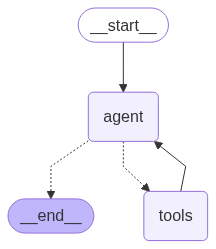

In [60]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))